In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from datetime import datetime
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers.legacy import Nadam
from tensorflow.keras.optimizers import AdamW
#from tensorflow.keras.optimizers.legacy import AdamW

from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.callbacks import EarlyStopping

In [3]:
sns.set_theme(rc={'figure.figsize':(16,8)})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving 01_06_2021_to_20_06_2023_prepared_df_25.csv to 01_06_2021_to_20_06_2023_prepared_df_25.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_34.csv to 01_06_2021_to_20_06_2023_prepared_df_34.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_36.csv to 01_06_2021_to_20_06_2023_prepared_df_36.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_52.csv to 01_06_2021_to_20_06_2023_prepared_df_52.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_95.csv to 01_06_2021_to_20_06_2023_prepared_df_95.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_180.csv to 01_06_2021_to_20_06_2023_prepared_df_180.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_206.csv to 01_06_2021_to_20_06_2023_prepared_df_206.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_272.csv to 01_06_2021_to_20_06_2023_prepared_df_272.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_287.csv to 01_06_2021_to_20_06_2023_prepared_df_287.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_368.csv to 01_06_2021_to_20_06_2023_prepared_df_368.csv
Saving 01_

In [5]:
csv_list = [25, 34, 36, 52, 95, 180, 206, 272, 287, 368, 781, 875, 1435, 5435, 6287]

In [6]:
df_dict = {}
for x in csv_list:
    df_dict[f"df_{x}"] = pd.read_csv(f'01_06_2021_to_20_06_2023_prepared_df_{x}.csv', parse_dates=[0], index_col=[0])

In [7]:
for key, value in df_dict.items():
  print(key)

df_25
df_34
df_36
df_52
df_95
df_180
df_206
df_272
df_287
df_368
df_781
df_875
df_1435
df_5435
df_6287


In [8]:
# This function will create a slice of data from a specified random starting position.
# The random position must be generated externally.

def get_Xi_yi(df_X,
              df_y,
              random_start,
              X_length=28,
              y_length=7):

#     must define a random_start:int for function to run
    Xi = df_X.iloc[random_start-X_length:random_start]
    yi = df_y.iloc[random_start:random_start+y_length]

    return Xi, yi


In [9]:
# The main data selection function.
# This function will generate all random slices based on the length of the dataframe passed.
# Important to note, if val state is set to true, it will only generate data slices after the val_cutoff point.

def get_X_y(df,
            X_length=56,
            y_length=14,
            number_of_sequences=51,
            number_of_targets=1,
            n_pca=10,
            val=False,
            val_cutoff=0.8):

#     limit dataframes to length for train/test splits
    df_X = df.copy()
    df_y = df.iloc[:, :number_of_targets].copy()

#     convert and scale X dataframe to PCA to solve dimensionality problem
    scaler = MinMaxScaler()
    df_X_scaled = scaler.fit_transform(df_X)
    pca = PCA(n_components=n_pca).fit(df_X_scaled)
    df_X_proj = pd.DataFrame(pca.transform(df_X_scaled))
    df_X_proj.index = df_X.index

#     create unique list to sample random datapoints from
    if val:
        sample_list = list(range(int(len(df_y)*val_cutoff), int(len(df_y)-y_length)))
    if not val:
        sample_list = list(range(int(X_length), int(len(df_y)-y_length)))
    random.shuffle(sample_list)

#     empty lists to append data to, will create 3D dataframe here
    X, y = [], []

#     for loop to select ith values from data
    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(df_X_proj, df_y, sample_list.pop(-1), X_length, y_length)
        X.append(Xi.values.tolist())
        y.append(yi.values.tolist())

    return np.array(X), np.array(y)

In [18]:
# Create X_train_dict, y_train_dict
X_train_dict = {}
y_train_dict = {}

for key, value in df_dict.items():
  X_train, y_train = get_X_y(value.iloc[:int(len(value)*0.6)],
                            X_length=56,
                            y_length=14,
                            number_of_sequences=50,
                            number_of_targets=1)
  y_train = y_train[:, :, 0]
  X_train_dict[f'{key}'] = X_train
  y_train_dict[f'{key}'] = y_train

In [ ]:
#X_train, y_train = get_X_y(combined_df.iloc[:int(len(combined_df)*0.6)],
                            X_length=56,
                            y_length=14,
                            number_of_sequences=50,
                            number_of_targets=1)

In [ ]:
#y_train = y_train[:, :, 0]

In [19]:
print(X_train_dict['df_25'].shape, y_train_dict['df_25'].shape)

(50, 56, 10) (50, 14)


In [20]:
# Create X_train_dict, y_train_dict
X_val_dict = {}
y_val_dict = {}

for key, value in df_dict.items():
  X_val, y_val = get_X_y(value.iloc[:int(len(value)*0.8)],
                        X_length=56,
                        y_length=14,
                        number_of_sequences=15,
                        number_of_targets=1,
                        val=True,
                        val_cutoff=0.6)
  y_val = y_val[:, :, 0]
  X_val_dict[f'{key}'] = X_val
  y_val_dict[f'{key}'] = y_val

In [ ]:
#y_val = y_val[:, :, 0]

In [21]:
print(X_val_dict['df_25'].shape, y_val_dict['df_25'].shape)

(15, 56, 10) (15, 14)


In [22]:
# Create X_test_dict, y_test_dict
X_test_dict = {}
y_test_dict = {}

for key, value in df_dict.items():
  X_test, y_test = get_X_y(value.iloc[:int(len(value)*0.99)],
                          X_length=56,
                          y_length=14,
                          number_of_sequences=15,
                          number_of_targets=1,
                          val=True,
                          val_cutoff=0.8)
  y_test = y_test[:, :, 0]
  X_test_dict[f'{key}'] = X_test
  y_test_dict[f'{key}'] = y_test

In [ ]:
#y_test = y_test[:, :, 0]

In [27]:
print(X_test_dict['df_25'].shape, y_test_dict['df_25'].shape)

(15, 56, 10) (15, 14)


In [29]:
# y normalize wihout log
y_train_scaled_dict = {}
y_test_scaled_dict = {}
y_val_scaled_dict = {}

for key, value in y_train_dict.items():
  y_scaler = MinMaxScaler()
  y_scaler.fit(value)

  y_train_scaled_dict[f'{key}'] = y_scaler.transform(value)
  y_test_scaled_dict[f'{key}'] = y_scaler.transform(y_test_dict[key])
  y_val_scaled_dict[f'{key}'] = y_scaler.transform(y_val_dict[key])

In [30]:
input_shape = X_train_dict['df_25'].shape[1:]
output_shape = y_train_scaled_dict['df_25'].shape[1]
reg = regularizers.l1_l2(l1=0.04, l2=0.02)

In [61]:
models_dict ={}

for key, value in df_dict.items():

  # instantiate model
  model = Sequential()

  # masking
  # model.add(Masking(input_shape = input_shape))

  # hidden layer architecture
  model.add(LSTM(200, return_sequences=True,\
                input_shape = input_shape))

  model.add(LSTM(200, return_sequences=True,
                recurrent_regularizer=reg,
                # dropout=0.2
                ))

  model.add(LSTM(200, return_sequences=True,
                recurrent_regularizer=reg,
                # dropout=0.2
                ))

  model.add(LSTM(200, return_sequences=True,
                recurrent_regularizer=reg,
                # dropout=0.2
                ))

  # pass final sequences
  model.add(LSTM(200, return_sequences=False))

  #can add dense layer
  #droput layers/ recurrent dropout
  #regularizers

  # prediction layer
  model.add(Dense(output_shape, activation = 'linear'))

  models_dict[f'{key}'] = model

In [62]:
models_dict['df_34'].summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_310 (LSTM)             (None, 56, 200)           168800    
                                                                 
 lstm_311 (LSTM)             (None, 56, 200)           320800    
                                                                 
 lstm_312 (LSTM)             (None, 56, 200)           320800    
                                                                 
 lstm_313 (LSTM)             (None, 56, 200)           320800    
                                                                 
 lstm_314 (LSTM)             (None, 200)               320800    
                                                                 
 dense_62 (Dense)            (None, 14)                2814      
                                                                 
Total params: 1,454,814
Trainable params: 1,454,814
N

In [63]:
optimizer = AdamW(learning_rate=0.01,
                  beta_1=0.8,
                  beta_2=0.999)
    #learning_rate=0.00003,
                 # beta_1=0.8,
                  #epsilon=1e-18)

Epoch 1/500
2/2 - 11s - loss: 498.6653 - mae: 0.4030 - val_loss: 284.2138 - val_mae: 0.7022 - 11s/epoch - 5s/step
Epoch 2/500
2/2 - 0s - loss: 256.3270 - mae: 0.4427 - val_loss: 163.5786 - val_mae: 0.5219 - 101ms/epoch - 50ms/step
Epoch 3/500
2/2 - 0s - loss: 153.1322 - mae: 0.5825 - val_loss: 118.3953 - val_mae: 0.5224 - 97ms/epoch - 48ms/step
Epoch 4/500
2/2 - 0s - loss: 111.5314 - mae: 0.2852 - val_loss: 94.2185 - val_mae: 0.2998 - 82ms/epoch - 41ms/step
Epoch 5/500
2/2 - 0s - loss: 90.1242 - mae: 0.2100 - val_loss: 75.3714 - val_mae: 0.2672 - 86ms/epoch - 43ms/step
Epoch 6/500
2/2 - 0s - loss: 73.9367 - mae: 0.2012 - val_loss: 61.4368 - val_mae: 0.2943 - 74ms/epoch - 37ms/step
Epoch 7/500
2/2 - 0s - loss: 59.0891 - mae: 0.1897 - val_loss: 55.2229 - val_mae: 0.2982 - 75ms/epoch - 37ms/step
Epoch 8/500
2/2 - 0s - loss: 52.7105 - mae: 0.1918 - val_loss: 44.6651 - val_mae: 0.2910 - 73ms/epoch - 37ms/step
Epoch 9/500
2/2 - 0s - loss: 43.6123 - mae: 0.1950 - val_loss: 41.1735 - val_mae: 

1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Epoch 1/500


StagingError: ignored

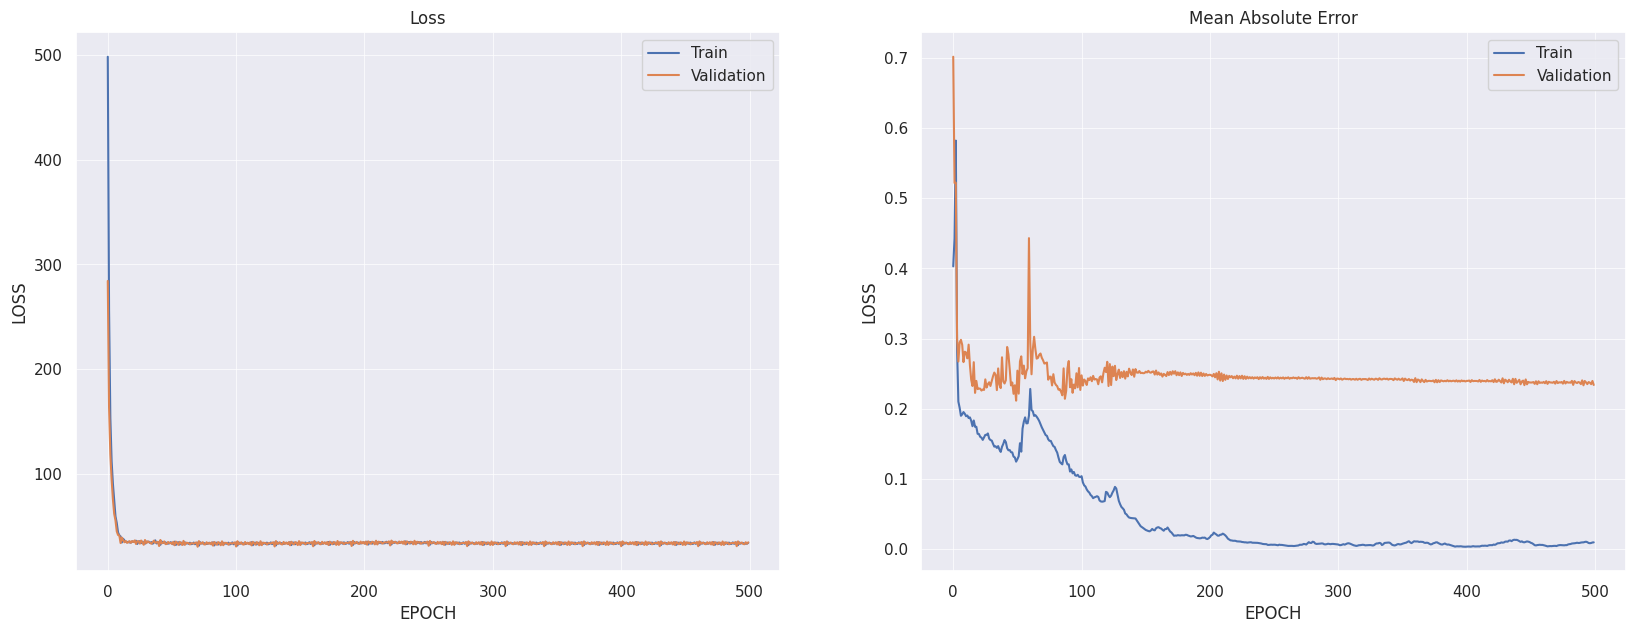

In [64]:

history_dict = {}

for key, value in df_dict.items():
  models_dict[key].compile(
      loss=['logcosh'],
      metrics=['mae'],
      optimizer=optimizer
  )

  es = EarlyStopping(
      patience=10,
      restore_best_weights=True
  )

for key, value in df_dict.items():
  history = models_dict[key].fit(
                  X_train_dict[key],
                  y_train_scaled_dict[key],
                  batch_size = 32,
                  epochs = 500,
                  shuffle = False,
                  verbose = 2,
                  validation_data = (X_val_dict[key], y_val_scaled_dict[key]),
                 # callbacks=[es]
  )

  history_dict[f'{key}'] = history

  y_pred = model.predict(X_test_dict[key])

  y_pred = y_scaler.inverse_transform(y_pred)

  dl_error = np.mean(abs(y_pred - y_test_dict[key]))

  base_error = np.mean(abs((value[['nb_cars']]-value[['nb_cars']].shift(14)).dropna()))[0]

  plot_history(history);


In [ ]:
y_pred = model.predict(X_test)

y_pred = y_scaler.inverse_transform(y_pred)
y_pred = np.exp(y_pred)

In [ ]:
for i in range(y_pred.shape[0]):
    fig = plt.gcf(); fig.set_size_inches(20, 12);
    plt.plot(y_pred[i, :], c="blue", label="Prediction")
    plt.plot(y_test[i, :], c="red", label="Test")
#     plt.ylim(0, 430)
    plt.legend(loc='upper right')
    plt.show();

In [ ]:
dl_error = np.mean(abs(y_pred - y_test))

In [ ]:
base_error = np.mean(abs((combined_df[['nb_cars']]-combined_df[['nb_cars']].shift(14)).dropna()))[0]
base_error

In [ ]:
print(
    f"DL model predicts with an average error of        {round(dl_error, 2)} cars"
    "\n"
    f"2 Weeks before predicts with an average error of  {round(base_error, 2)} cars"
)

In [38]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: LOSS ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('LOSS')
    ax[0].set_xlabel('EPOCH')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS: MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Mean Absolute Error')
    ax[1].set_ylabel('LOSS')
    ax[1].set_xlabel('EPOCH')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

In [ ]:
plot_history(history);